In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Unit 4 Exercises: Tinkering Hierarchical Models

These exercises are designed to force you to look at the nuances of the models we looked at in class, while exploring some "what ifs". There's also some mild data wrangling for you to enjoy at in task6.



**Task1**:

Redo the chemical shift hierarchical model, execpt with all Student T  and Half Student T likelihood and priors.

Then, compare group posteriors of the normal chem shift model with your new Student T model using a ridge plot.

In [2]:
url_cs = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/chemical_shifts_theo_exp.csv'
cs_data = pd.read_csv(url_cs)
diff_TminusE = cs_data.theo - cs_data.exp
cs_data.insert(loc=4,column='diff_TminusE',value=diff_TminusE)
aa_encode = pd.Categorical(cs_data['aa'])
aa_encode
aa_idx = aa_encode.codes
aa_idx
aa_coords = {"aa": aa_encode.categories}
aa_coords

{'aa': Index(['ALA', 'ARG', 'ASN', 'ASP', 'GLN', 'GLU', 'GLY', 'HIS', 'ILE', 'LEU',
        'LYS', 'MET', 'PHE', 'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'],
       dtype='object')}

In [3]:
with pm.Model(coords=aa_coords) as cs_h_StudentT_model:
    s_mu = pm.StudentT('s_mu', mu = 0, sigma = 5, nu = 5)
    s_sd = pm.HalfStudentT('s_sd', sigma = 5,nu =10)
    s_nu = pm.HalfStudentT('s_nu', sigma = 5,nu =10) #I wasnt sure what to put for priors so I just asked Yeshi what he did and he said to look at the api and just upscale the ratio of sigma and nu


    μ = pm.StudentT('μ',
                  mu = s_mu,
                  sigma = s_sd,
                  nu =  s_nu,
                  dims = "aa")

    σ = pm.HalfStudentT('σ',
                       sigma = 5,
                       nu = 10,
                      dims = "aa")
    v = pm.HalfStudentT('v',
                   sigma = 5, nu = 10,
                   dims = "aa")

    y = pm.StudentT('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  nu = v[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h_StudentT = pm.sample()

Output()

Output()

In [4]:
with pm.Model(coords=aa_coords) as cs_h_model:
    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 10)

    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd,
                  dims = "aa")

    σ = pm.HalfNormal('σ', sigma = 10,
                      dims = "aa")

    y = pm.Normal('y',
                  mu = μ[aa_idx],
                  sigma = σ[aa_idx],
                  observed = cs_data.diff_TminusE)

    idata_cs_h = pm.sample()

Output()

Output()

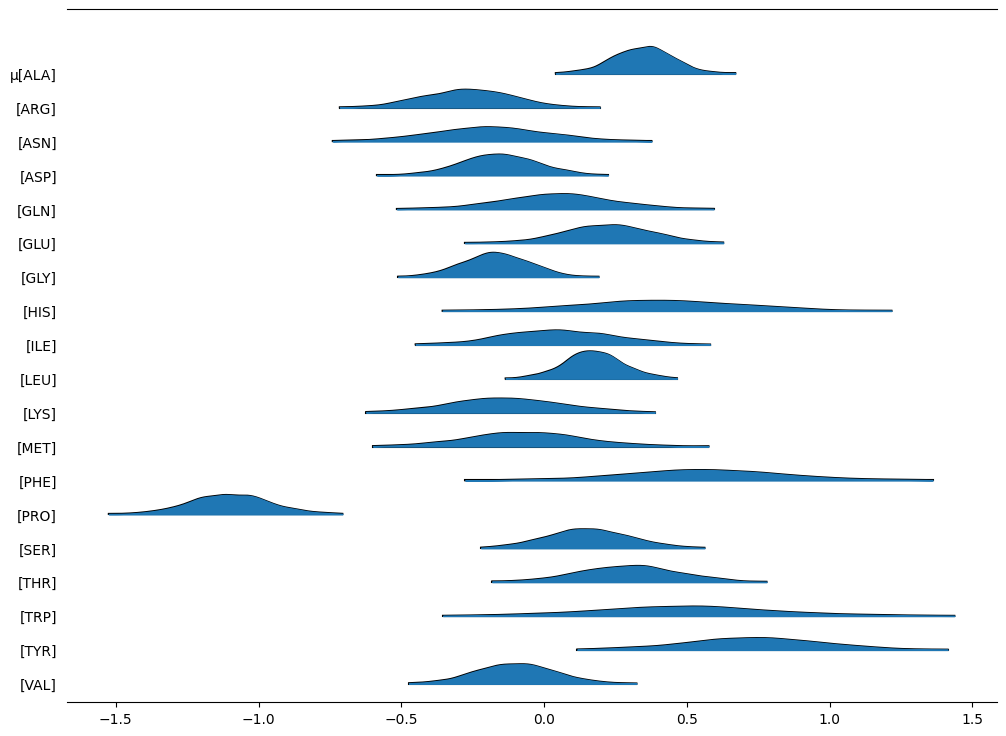

In [13]:
axes = az.plot_forest(idata_cs_h, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)


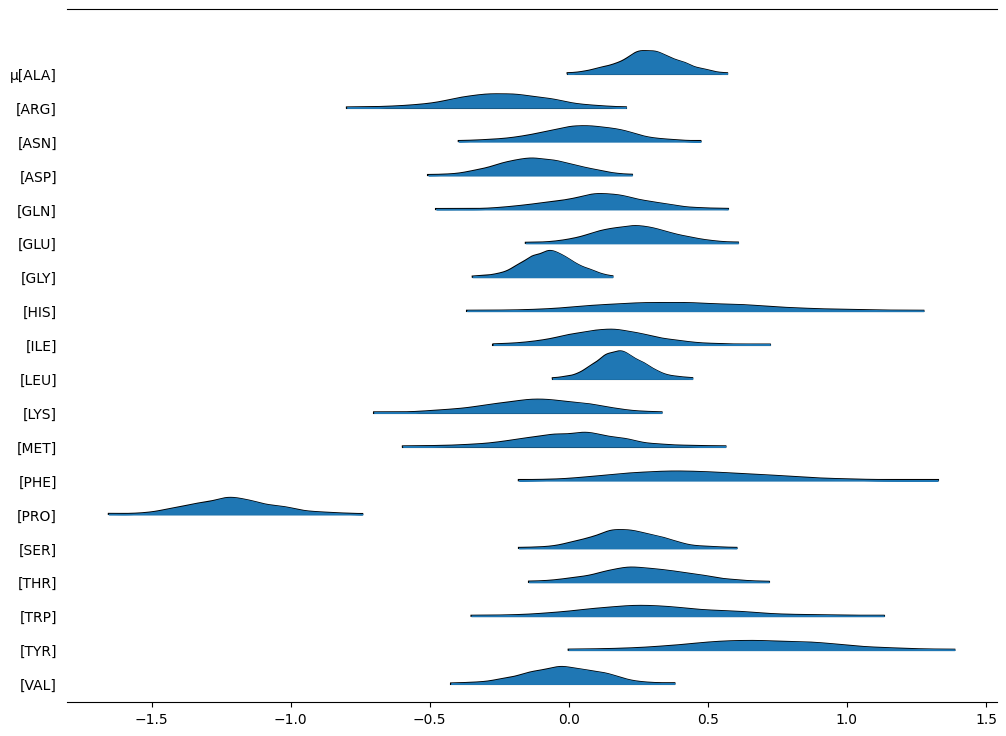

In [12]:
axes = az.plot_forest(idata_cs_h_StudentT , kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)


Both of the graphs and curves look very similar, however a very slight difference is the studentT curves are slightly thinner. For example if you look at [PRO] on both of the plots, the studentT climaxes at a sharper point, while the normal likelihood plateaus.

Additionally, the sizes and position of each curve vary slightly between the two plots. For example, the original likelihood has a lower standard deviation for [ALA], while [HIS] is shown to be shifted to the right in the studentT likelihood.

**Task2**:

Run a posterior predictive check for both models. Which seems to fit the data better?

Output()

(-10.0, 10.0)

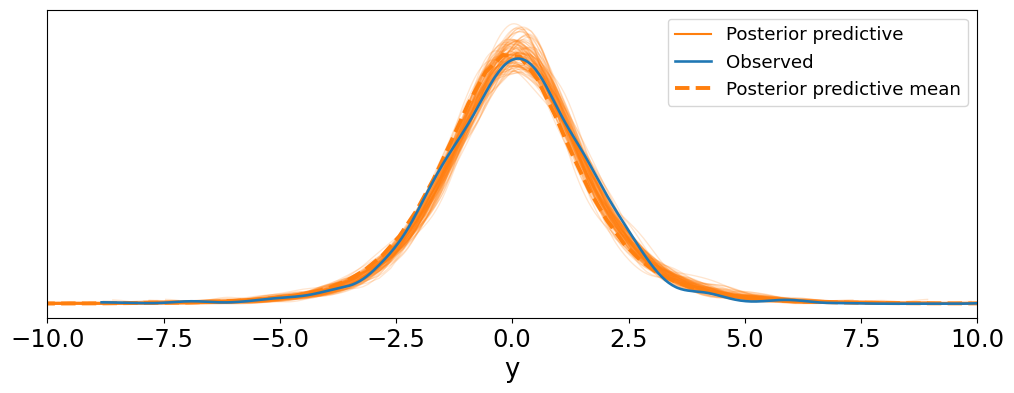

In [17]:
pm.sample_posterior_predictive(idata_cs_h_StudentT, model=cs_h_StudentT_model, extend_inferencedata=True)

alt = az.plot_ppc(idata_cs_h_StudentT, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
alt.set_xlim(-10,10)

Output()

(-10.0, 10.0)

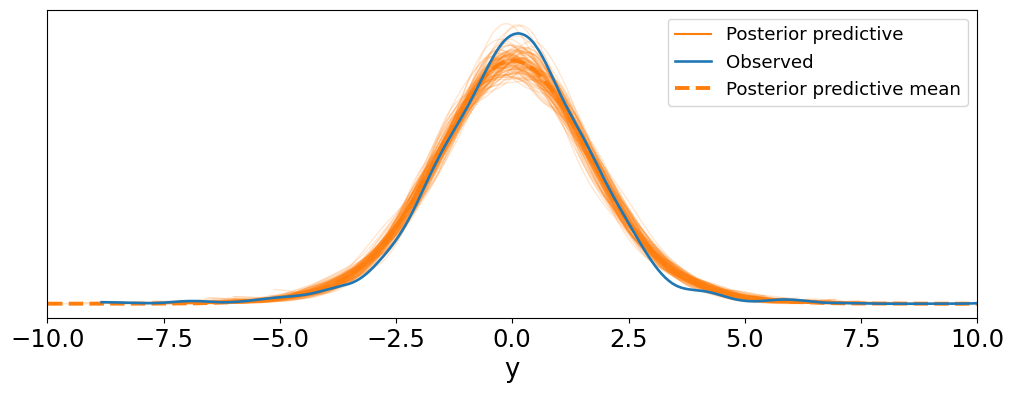

In [18]:
pm.sample_posterior_predictive(idata_cs_h, model=cs_h_model, extend_inferencedata=True)

alt = az.plot_ppc(idata_cs_h, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
alt.set_xlim(-10,10)

StudentT looks a lot closer to the PPC mean than the original likelihood. The peaks match very well for the StudentT while the original likelihood wildly overshoots. While the stretch from 1 to 2.5 looks a lot closer to the PPC mean for the original likelihood, I still think that the shape is a lot better represented from the studentT likelihood.

**Task3**:

Redo the soccer model, but this time, assume the groups are independent. This will be a non-hierarchical model.

In [8]:
url_sccr = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/football_players.csv'
sccr_data = pd.read_csv(url_sccr,dtype={'position':'category'})
pos_idx = sccr_data.position.cat.codes.values
pos_codes = sccr_data.position.cat.categories
sccr_coords = {"pos": pos_codes}

In [19]:

with pm.Model(coords = sccr_coords) as sccr_model:
    μ_p = pm.Beta('μ_p', mu = .1, nu = 45, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    xlx = pm.Binomial('gs',
                    n = sccr_data.shots.values,
                    p = θ,
                    observed = sccr_data.goals.values)


    idata_sccr = pm.sample(target_accept = 0.95)

#why is this so long :(......




Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task4**:

Run plot trace and rhat on your inference data object for the non-hierarchical soccer model. How does this compare to the hierarchical model?

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

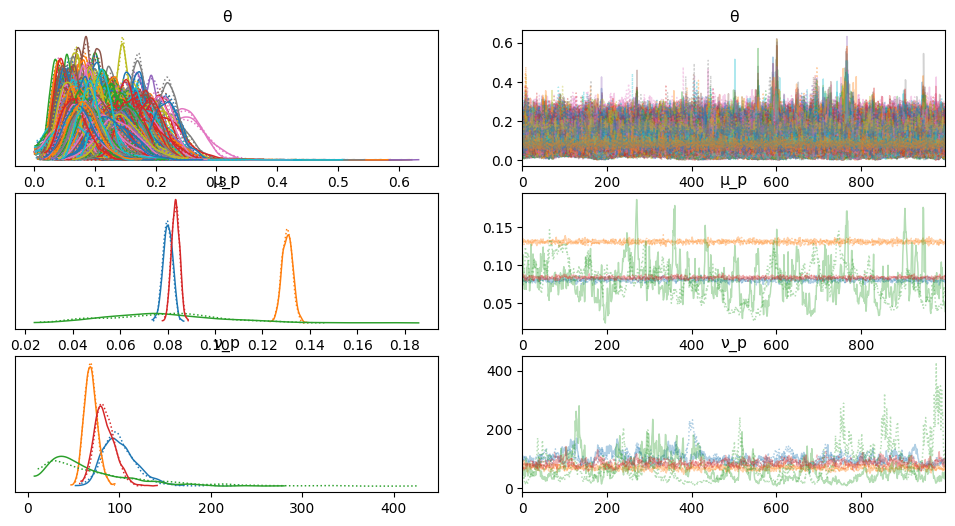

In [20]:
az.plot_trace(idata_sccr)
# >:(

In [10]:
az.rhat(idata_sccr)

Shape validation failed: input_shape: (1, 172), minimum_shape: (chains=2, draws=4)


<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB nan nan nan nan nan ... nan nan nan nan nan
    μ_p      (pos) float64 32B nan nan nan nan
    ν_p      (pos) float64 32B nan nan nan nan

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


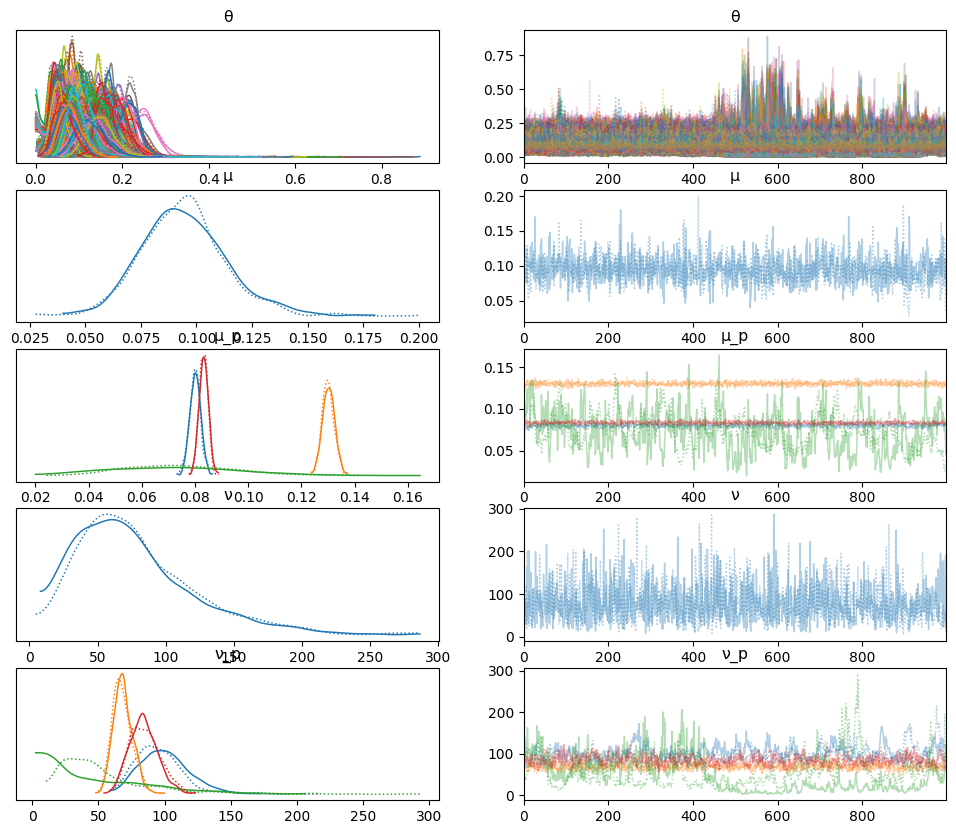

In [22]:
with pm.Model(coords = sccr_coords) as sccr_h_model:
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)

    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    xlx = pm.Binomial('gs',
                    n = sccr_data.shots.values,
                    p = θ,
                    observed = sccr_data.goals.values)

    idata_sccr_h = pm.sample(target_accept = 0.95)

    az.plot_trace(idata_sccr_h)
    az.rhat(idata_sccr_h)

    # so long for what smh

The non-heirarchal model seems to match the data better, as seen especially in the bottom left graph, but you can see slightly larger variation in the other graphs for the heirarchel model. Also there are 2 extra graphs for the heirarchal model. Other than that, they look very similar to me.

**Task5**:

Plot the posterior of the means for each soccer position in the non-hierarchical model.

How do these posteriors compare to the hierarchical model we did in class?

array([<Axes: >], dtype=object)

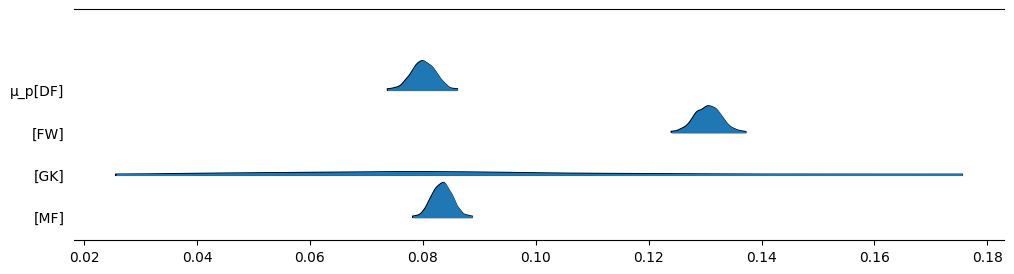

In [23]:
az.plot_forest(idata_sccr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

array([<Axes: >], dtype=object)

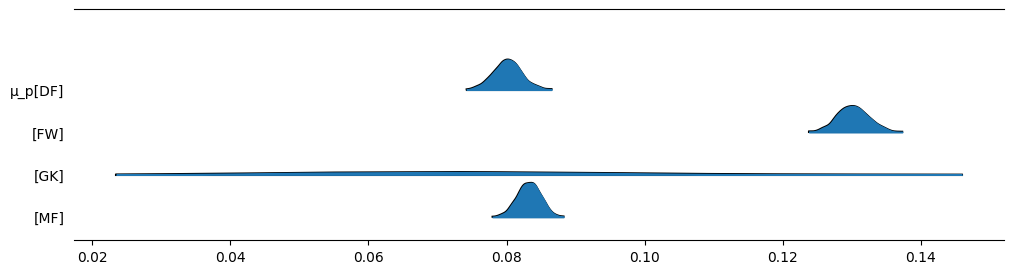

In [24]:
az.plot_forest(idata_sccr_h, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)


The heirarchal model has higher and more scattered averages for each position.

**Task6**:

Redo the soccer model as a hierarchical model, but remove all the goalkeepers (GK) from the data. In other words, run a hierarchical model on only the defenders, midfielders, and forwards.

In [28]:
#I wasnt sure how to get rid of the gk column so i aksed my friend yeshi how to do so and he showed me the api for panda
sccr_data
nogk = sccr_data.loc[sccr_data["position"] != "GK"]
nogk
pos_idx = nogk.position.cat.codes.values
pos_codes = nogk.position.cat.categories
sccr_coords_gkless = {"pos": pos_codes}

In [31]:
with pm.Model(coords = sccr_coords_gkless) as sccr_h_model:
    μ = pm.Beta('μ', alpha = 2, beta = 20)
    ν = pm.Gamma('ν', mu = 55, sigma = 45)

    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "pos")

    ν_p = pm.Gamma('ν_p', mu = 55, sigma = 45, dims="pos")

    θ = pm.Beta('θ', mu = μ_p[pos_idx], nu = ν_p[pos_idx])

    xlx = pm.Binomial('gs',
                    n = nogk.shots.values,
                    p = θ,
                    observed = nogk.goals.values)
    idata_sccr_gkless = pm.sample(target_accept = 0.95) #IDK why target accpet is 0.95 i just copied it from the notes and it works


# >:(

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Task7**:

Compare the plot trace and rhat results for the hierarchical model with GKs and without GKs. Then answer the following questions:
- Which model was easier for pymc to process?
- What do we lose by dropping Gks from the data set? What do we gain?

<xarray.Dataset> Size: 40kB
Dimensions:  (θ_dim_0: 2517, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 20kB 0 1 2 3 4 5 ... 2511 2512 2513 2514 2515 2516
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 20kB 0.9994 1.0 0.9997 1.002 ... 1.0 1.003 0.9997
    μ        float64 8B 1.001
    μ_p      (pos) float64 32B 1.002 1.003 1.003 1.001
    ν        float64 8B 1.001
    ν_p      (pos) float64 32B 1.016 1.002 1.001 1.004

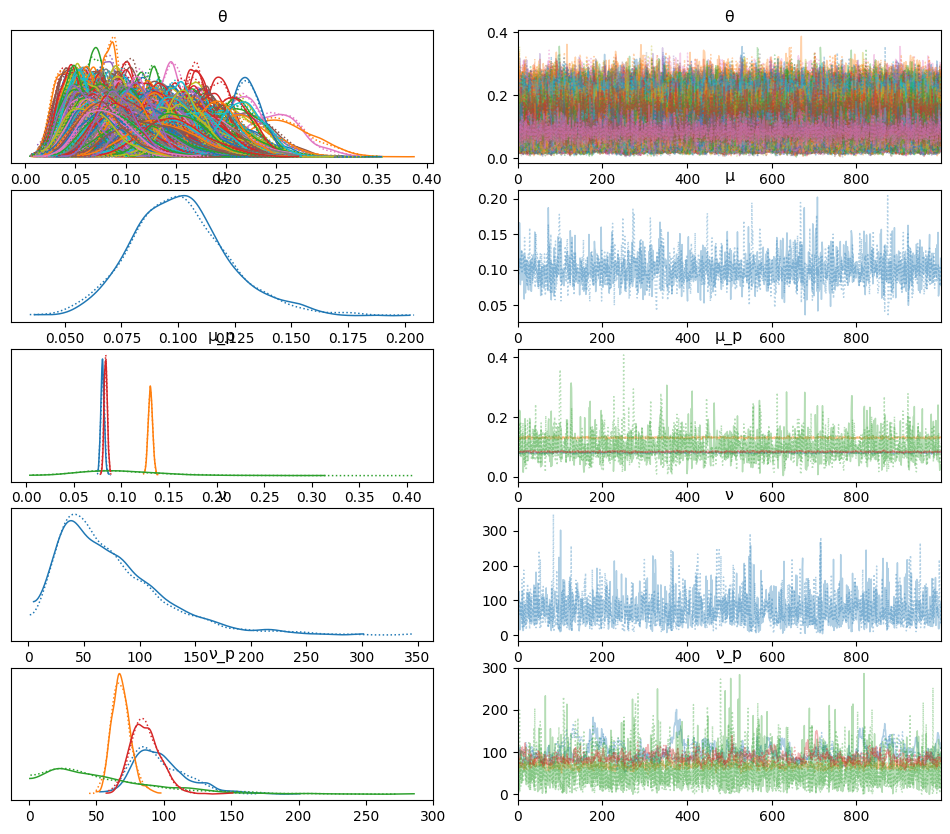

In [32]:
az.plot_trace(idata_sccr_gkless)
az.rhat(idata_sccr_gkless)

<xarray.Dataset> Size: 43kB
Dimensions:  (θ_dim_0: 2682, pos: 4)
Coordinates:
  * θ_dim_0  (θ_dim_0) int64 21kB 0 1 2 3 4 5 ... 2676 2677 2678 2679 2680 2681
  * pos      (pos) <U2 32B 'DF' 'FW' 'GK' 'MF'
Data variables:
    θ        (θ_dim_0) float64 21kB 1.001 1.001 1.004 1.0 ... 1.003 1.0 0.9999
    μ        float64 8B 1.008
    μ_p      (pos) float64 32B 1.005 1.003 1.044 1.003
    ν        float64 8B 1.003
    ν_p      (pos) float64 32B 1.047 1.002 1.387 1.003

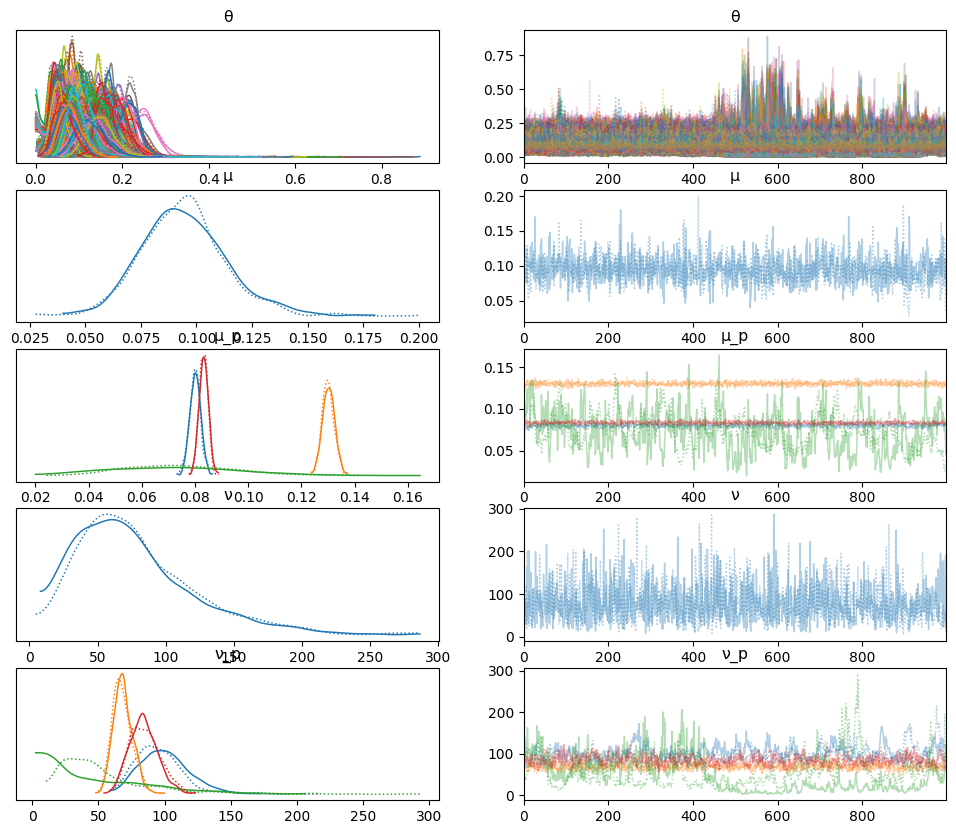

In [33]:
az.plot_trace(idata_sccr_h)
az.rhat(idata_sccr_h)

The model without goalkeepers (GKs) was easier for PyMC to process, as removing GKs reduced the complexity, making it simpler and faster for the model to converge.

By dropping GKs, we lose specific insights into this position, potentially overlooking unique patterns related to goalkeeping performance. However, we gain a simpler model with faster convergence and potentially better stability, as the remaining positions have more similar characteristics that the model can more easily handle.